# 1.9e: Bitwise Black Hole Separations

From 1.9d we know the 13 black holes are separated by 1-11 representable numbers (uint16 steps).

**Question:** When we look at the actual bit patterns, what's changing?

**Method:**
1. For each pairwise separation, decode both values into (sign, exponent, mantissa)
2. Compare bit-by-bit: which bits differ?
3. Categorize separations:
   - Same exponent, mantissa differs by 1-N bits
   - Exponent boundary crossing (mantissa wraps 127→0, exp increments)
   - Exponent jump (exp differs by >1)
4. Show bit patterns side-by-side for smallest separations

This reveals whether the black holes are separated by single-bit flips or more complex patterns.

## Parameters

In [1]:
# Model to analyze
MODEL_NAME = "Qwen3-4B-Instruct-2507"

# Active dimensions from 1.9c
ACTIVE_DIMS = [216, 282, 322, 450, 993, 1008, 1149, 1155, 1272, 1382, 
               1403, 1435, 1487, 1564, 1763, 2012, 2040, 2079, 2143, 2479]

# How many example separations to show in detail per category
N_EXAMPLES = 5

## Imports

In [2]:
import torch
import ml_dtypes
import numpy as np
import matplotlib.pyplot as plt
from safetensors.torch import load_file
from pathlib import Path
from collections import defaultdict

## Helper Functions

In [3]:
def decode_bfloat16_bits(value_bf16):
    """Decode a bfloat16 value into its bit components."""
    bits_uint16 = np.frombuffer(value_bf16.tobytes(), dtype=np.uint16)[0]
    bits_binary = format(bits_uint16, '016b')
    
    sign_bit = bits_binary[0]
    exponent_bits = bits_binary[1:9]
    mantissa_bits = bits_binary[9:16]
    
    sign = int(sign_bit)
    exponent = int(exponent_bits, 2)
    mantissa = int(mantissa_bits, 2)
    
    return {
        'bits_uint16': bits_uint16,
        'bits_binary': bits_binary,
        'sign': sign,
        'exponent': exponent,
        'mantissa': mantissa,
        'sign_bit': sign_bit,
        'exponent_bits': exponent_bits,
        'mantissa_bits': mantissa_bits
    }

def compare_bit_patterns(decoded_a, decoded_b):
    """Compare two decoded bit patterns and return differences."""
    sign_differs = decoded_a['sign'] != decoded_b['sign']
    exp_diff = decoded_b['exponent'] - decoded_a['exponent']
    mant_diff = decoded_b['mantissa'] - decoded_a['mantissa']
    
    # Count differing bits
    exp_bits_differ = bin(int(decoded_a['exponent_bits'], 2) ^ int(decoded_b['exponent_bits'], 2)).count('1')
    mant_bits_differ = bin(int(decoded_a['mantissa_bits'], 2) ^ int(decoded_b['mantissa_bits'], 2)).count('1')
    
    return {
        'sign_differs': sign_differs,
        'exp_diff': exp_diff,
        'mant_diff': mant_diff,
        'exp_bits_differ': exp_bits_differ,
        'mant_bits_differ': mant_bits_differ,
        'total_bits_differ': (1 if sign_differs else 0) + exp_bits_differ + mant_bits_differ
    }

def categorize_separation(comparison):
    """Categorize a separation based on bit pattern differences."""
    if comparison['sign_differs']:
        return 'sign_flip'
    elif comparison['exp_diff'] == 0:
        return 'same_exponent'
    elif comparison['exp_diff'] == 1:
        return 'exponent_boundary'
    else:
        return 'exponent_jump'

## Load Data

In [4]:
# Load W in bfloat16
W_path = Path(f"../tensors/{MODEL_NAME}/W.safetensors")
W_bf16 = load_file(W_path)["W"]

print(f"Loaded W: {W_bf16.shape}")
print(f"Dtype: {W_bf16.dtype}")

Loaded W: torch.Size([151936, 2560])
Dtype: torch.bfloat16


In [5]:
# Load corrected core data from 1.9b
core_path = Path(f"../tensors/{MODEL_NAME}/1.9b_core_bfloat16.safetensors")
core_data = load_file(core_path)

core_token_ids = core_data["core_token_ids"].to(torch.int64)
bh_labels = core_data["bh_labels"].to(torch.int64)
n_black_holes = core_data["n_black_holes"].item()

print(f"\nLoaded core data: {n_black_holes} black holes")


Loaded core data: 13 black holes


## Extract Black Hole Representative Vectors

In [6]:
print("\nExtracting black hole representative vectors...\n")

# For each black hole, get the first token
bh_token_ids = []
bh_populations = []

for bh_id in range(n_black_holes):
    mask = bh_labels == bh_id
    tokens_in_bh = core_token_ids[mask]
    bh_token_ids.append(tokens_in_bh[0].item())
    bh_populations.append(len(tokens_in_bh))
    print(f"BH{bh_id:2d}: {len(tokens_in_bh):4,} tokens")

# Extract vectors in bfloat16
bh_vectors_bf16 = [W_bf16[token_id] for token_id in bh_token_ids]

# Convert to uint16 (raw bits)
bh_vectors_uint16 = [vec.cpu().view(torch.uint16).numpy() for vec in bh_vectors_bf16]

print(f"\n✓ Extracted {len(bh_vectors_bf16)} black hole vectors")
print(f"  Converted to uint16 (raw bits)")


Extracting black hole representative vectors...

BH 0:  814 tokens
BH 1:  704 tokens
BH 2:  306 tokens
BH 3:  228 tokens
BH 4:   11 tokens
BH 5:   10 tokens
BH 6:    6 tokens
BH 7:    5 tokens
BH 8:    4 tokens
BH 9:    4 tokens
BH10:    3 tokens
BH11:    3 tokens
BH12:    2 tokens

✓ Extracted 13 black hole vectors
  Converted to uint16 (raw bits)


## Analyze All Pairwise Separations

In [7]:
print("\nAnalyzing all pairwise separations across all dimensions...\n")

# Store all separations with their details
separations = []

for dim in ACTIVE_DIMS:
    # Extract uint16 values for this dimension
    values_uint16 = [vec[dim] for vec in bh_vectors_uint16]
    
    # Convert to bfloat16 for decoding
    values_bf16 = [np.frombuffer(np.uint16(v).tobytes(), dtype=ml_dtypes.bfloat16)[0] 
                   for v in values_uint16]
    
    # Decode all values
    decoded_values = [decode_bfloat16_bits(v) for v in values_bf16]
    
    # Compare all pairs
    for i in range(len(values_uint16)):
        for j in range(i+1, len(values_uint16)):
            # Skip if identical
            if values_uint16[i] == values_uint16[j]:
                continue
            
            # Ensure i < j in uint16 space for consistent comparison
            if values_uint16[i] > values_uint16[j]:
                i, j = j, i
            
            uint16_sep = int(values_uint16[j]) - int(values_uint16[i])
            
            comparison = compare_bit_patterns(decoded_values[i], decoded_values[j])
            category = categorize_separation(comparison)
            
            separations.append({
                'dim': dim,
                'bh_i': i,
                'bh_j': j,
                'uint16_sep': uint16_sep,
                'decoded_i': decoded_values[i],
                'decoded_j': decoded_values[j],
                'comparison': comparison,
                'category': category,
                'float_i': float(values_bf16[i]),
                'float_j': float(values_bf16[j])
            })

print(f"✓ Analyzed {len(separations):,} non-zero pairwise separations")


Analyzing all pairwise separations across all dimensions...

✓ Analyzed 741 non-zero pairwise separations


## Categorize Separations

In [8]:
print("\n" + "=" * 100)
print("SEPARATION CATEGORIES")
print("=" * 100)
print()

# Group by category
by_category = defaultdict(list)
for sep in separations:
    by_category[sep['category']].append(sep)

# Show counts
for category in ['same_exponent', 'exponent_boundary', 'exponent_jump', 'sign_flip']:
    count = len(by_category[category])
    pct = 100 * count / len(separations) if len(separations) > 0 else 0
    print(f"{category:20s}: {count:5,} separations ({pct:5.1f}%)")

print()
print(f"Total: {len(separations):,} separations")


SEPARATION CATEGORIES

same_exponent       :   741 separations (100.0%)
exponent_boundary   :     0 separations (  0.0%)
exponent_jump       :     0 separations (  0.0%)
sign_flip           :     0 separations (  0.0%)

Total: 741 separations


## Detailed Examples: Same Exponent Separations

In [9]:
print("\n" + "=" * 100)
print("SAME EXPONENT SEPARATIONS (mantissa differs only)")
print("=" * 100)
print()

same_exp = sorted(by_category['same_exponent'], key=lambda x: x['uint16_sep'])

if len(same_exp) > 0:
    print(f"Showing first {min(N_EXAMPLES, len(same_exp))} examples (sorted by uint16 separation):\n")
    
    for sep in same_exp[:N_EXAMPLES]:
        print(f"Dimension {sep['dim']}: BH{sep['bh_i']} → BH{sep['bh_j']}")
        print(f"  uint16 separation: {sep['uint16_sep']}")
        print(f"  Mantissa difference: {sep['comparison']['mant_diff']}")
        print(f"  Bits differ (mantissa): {sep['comparison']['mant_bits_differ']}")
        print()
        
        # Show bit patterns
        di = sep['decoded_i']
        dj = sep['decoded_j']
        print(f"  BH{sep['bh_i']}: [{di['sign_bit']}][{di['exponent_bits']}][{di['mantissa_bits']}]  "
              f"= {sep['float_i']:+.6e}  (exp={di['exponent']}, mant={di['mantissa']})")
        print(f"  BH{sep['bh_j']}: [{dj['sign_bit']}][{dj['exponent_bits']}][{dj['mantissa_bits']}]  "
              f"= {sep['float_j']:+.6e}  (exp={dj['exponent']}, mant={dj['mantissa']})")
        print()
        print("-" * 100)
        print()
else:
    print("(No same-exponent separations found)")


SAME EXPONENT SEPARATIONS (mantissa differs only)

Showing first 5 examples (sorted by uint16 separation):

Dimension 216: BH4 → BH0
  uint16 separation: 1
  Mantissa difference: 1
  Bits differ (mantissa): 6

  BH4: [1][01110101][1011111]  = -1.701355e-03  (exp=117, mant=95)
  BH0: [1][01110101][1100000]  = -1.708984e-03  (exp=117, mant=96)

----------------------------------------------------------------------------------------------------

Dimension 216: BH4 → BH5
  uint16 separation: 1
  Mantissa difference: 1
  Bits differ (mantissa): 6

  BH4: [1][01110101][1011111]  = -1.701355e-03  (exp=117, mant=95)
  BH5: [1][01110101][1100000]  = -1.708984e-03  (exp=117, mant=96)

----------------------------------------------------------------------------------------------------

Dimension 216: BH4 → BH7
  uint16 separation: 1
  Mantissa difference: 1
  Bits differ (mantissa): 6

  BH4: [1][01110101][1011111]  = -1.701355e-03  (exp=117, mant=95)
  BH7: [1][01110101][1100000]  = -1.708984e-

## Detailed Examples: Exponent Boundary Crossings

In [10]:
print("\n" + "=" * 100)
print("EXPONENT BOUNDARY CROSSINGS (exponent increments by 1)")
print("=" * 100)
print()

boundary = sorted(by_category['exponent_boundary'], key=lambda x: x['uint16_sep'])

if len(boundary) > 0:
    print(f"Showing first {min(N_EXAMPLES, len(boundary))} examples (sorted by uint16 separation):\n")
    
    for sep in boundary[:N_EXAMPLES]:
        print(f"Dimension {sep['dim']}: BH{sep['bh_i']} → BH{sep['bh_j']}")
        print(f"  uint16 separation: {sep['uint16_sep']}")
        print(f"  Exponent: {sep['decoded_i']['exponent']} → {sep['decoded_j']['exponent']} (+1)")
        print(f"  Mantissa: {sep['decoded_i']['mantissa']} → {sep['decoded_j']['mantissa']}")
        print()
        
        # Show bit patterns
        di = sep['decoded_i']
        dj = sep['decoded_j']
        print(f"  BH{sep['bh_i']}: [{di['sign_bit']}][{di['exponent_bits']}][{di['mantissa_bits']}]  "
              f"= {sep['float_i']:+.6e}")
        print(f"  BH{sep['bh_j']}: [{dj['sign_bit']}][{dj['exponent_bits']}][{dj['mantissa_bits']}]  "
              f"= {sep['float_j']:+.6e}")
        print()
        print("-" * 100)
        print()
else:
    print("(No exponent boundary crossings found)")


EXPONENT BOUNDARY CROSSINGS (exponent increments by 1)

(No exponent boundary crossings found)


## Distribution of Bit Differences

In [11]:
print("\n" + "=" * 100)
print("DISTRIBUTION OF BIT DIFFERENCES")
print("=" * 100)
print()

# Count by total bits differing
bits_differ_counts = defaultdict(int)
for sep in separations:
    bits_differ_counts[sep['comparison']['total_bits_differ']] += 1

print("Total bits differing (across all 16 bits):")
for n_bits in sorted(bits_differ_counts.keys()):
    count = bits_differ_counts[n_bits]
    pct = 100 * count / len(separations)
    print(f"  {n_bits:2d} bits differ: {count:5,} separations ({pct:5.1f}%)")

print()

# Count by mantissa bits differing (for same-exponent separations)
if len(same_exp) > 0:
    mant_bits_counts = defaultdict(int)
    for sep in same_exp:
        mant_bits_counts[sep['comparison']['mant_bits_differ']] += 1
    
    print("Mantissa bits differing (same-exponent separations only):")
    for n_bits in sorted(mant_bits_counts.keys()):
        count = mant_bits_counts[n_bits]
        pct = 100 * count / len(same_exp)
        print(f"  {n_bits:2d} mantissa bits differ: {count:5,} separations ({pct:5.1f}%)")


DISTRIBUTION OF BIT DIFFERENCES

Total bits differing (across all 16 bits):
   1 bits differ:   434 separations ( 58.6%)
   2 bits differ:    89 separations ( 12.0%)
   3 bits differ:    71 separations (  9.6%)
   4 bits differ:    44 separations (  5.9%)
   5 bits differ:    51 separations (  6.9%)
   6 bits differ:    52 separations (  7.0%)

Mantissa bits differing (same-exponent separations only):
   1 mantissa bits differ:   434 separations ( 58.6%)
   2 mantissa bits differ:    89 separations ( 12.0%)
   3 mantissa bits differ:    71 separations (  9.6%)
   4 mantissa bits differ:    44 separations (  5.9%)
   5 mantissa bits differ:    51 separations (  6.9%)
   6 mantissa bits differ:    52 separations (  7.0%)


## Histogram: uint16 Separation vs Category


Creating histogram of uint16 separations by category...



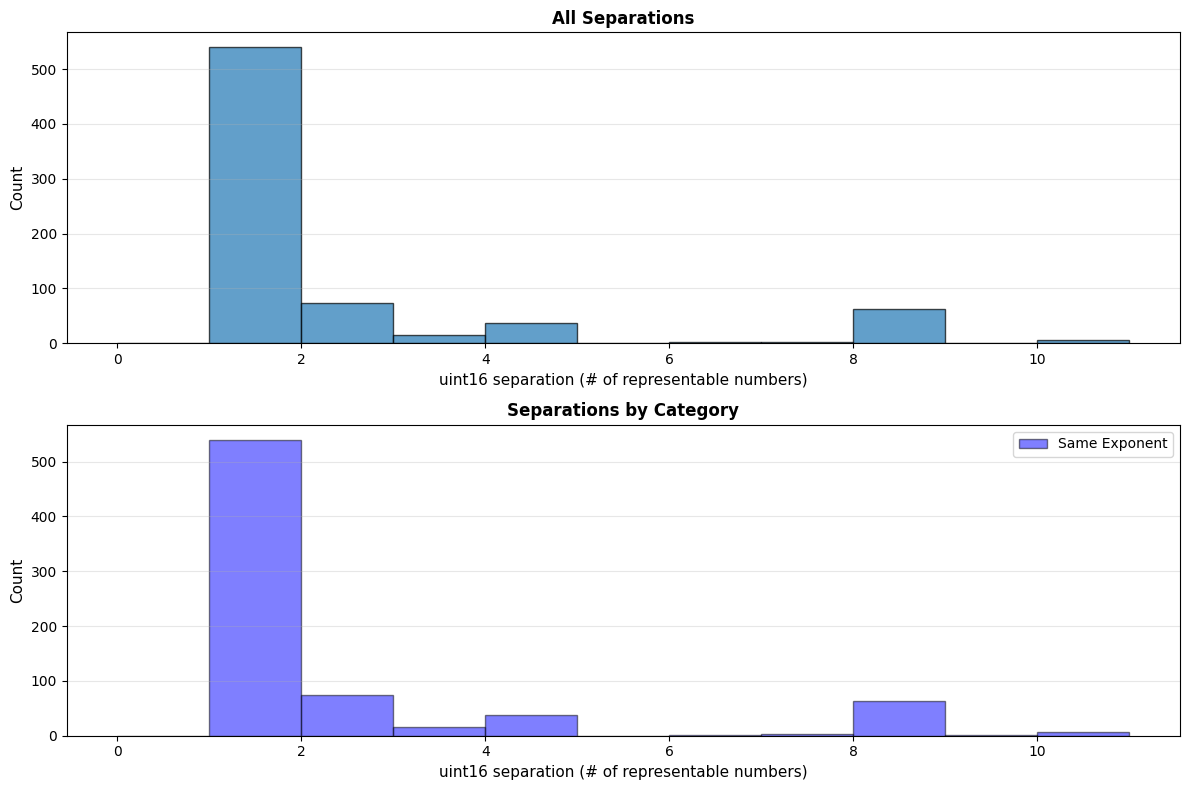

✓ Histogram complete


In [12]:
print("\nCreating histogram of uint16 separations by category...\n")

fig, axes = plt.subplots(2, 1, figsize=(12, 8), dpi=100)

# Top: All separations
ax = axes[0]
all_seps = [sep['uint16_sep'] for sep in separations]
ax.hist(all_seps, bins=range(0, max(all_seps)+2), edgecolor='black', alpha=0.7)
ax.set_xlabel('uint16 separation (# of representable numbers)', fontsize=11)
ax.set_ylabel('Count', fontsize=11)
ax.set_title('All Separations', fontsize=12, fontweight='bold')
ax.grid(axis='y', alpha=0.3)

# Bottom: By category
ax = axes[1]
categories = ['same_exponent', 'exponent_boundary', 'exponent_jump']
colors = ['blue', 'orange', 'red']
labels = ['Same Exponent', 'Exponent Boundary (+1)', 'Exponent Jump (>1)']

for category, color, label in zip(categories, colors, labels):
    seps = [sep['uint16_sep'] for sep in by_category[category]]
    if len(seps) > 0:
        ax.hist(seps, bins=range(0, max(all_seps)+2), 
                edgecolor='black', alpha=0.5, color=color, label=label)

ax.set_xlabel('uint16 separation (# of representable numbers)', fontsize=11)
ax.set_ylabel('Count', fontsize=11)
ax.set_title('Separations by Category', fontsize=12, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("✓ Histogram complete")

## Summary: Bitwise Structure

In [13]:
print("\n" + "=" * 100)
print("SUMMARY: BITWISE STRUCTURE OF BLACK HOLE SEPARATIONS")
print("=" * 100)
print()

# Find the minimum separation
min_sep = min(separations, key=lambda x: x['uint16_sep'])

print(f"Minimum separation: {min_sep['uint16_sep']} uint16 steps")
print(f"  Dimension {min_sep['dim']}: BH{min_sep['bh_i']} → BH{min_sep['bh_j']}")
print(f"  Category: {min_sep['category']}")
print(f"  Total bits differ: {min_sep['comparison']['total_bits_differ']}")
print()

# Count single-bit flips
single_bit_flips = [sep for sep in separations if sep['comparison']['total_bits_differ'] == 1]
print(f"Single-bit flips: {len(single_bit_flips):,} separations "
      f"({100*len(single_bit_flips)/len(separations):.1f}%)")

if len(single_bit_flips) > 0:
    # Where do single-bit flips occur?
    single_bit_categories = defaultdict(int)
    for sep in single_bit_flips:
        single_bit_categories[sep['category']] += 1
    
    print("  Categories:")
    for cat, count in sorted(single_bit_categories.items(), key=lambda x: -x[1]):
        print(f"    {cat}: {count}")

print()

# Exponent boundary statistics
if len(boundary) > 0:
    print(f"Exponent boundary crossings: {len(boundary):,} separations")
    print(f"  These occur when mantissa wraps from 127 → 0 and exponent increments.")
    print(f"  They represent transitions between different ULP scales.")
else:
    print("No exponent boundary crossings detected.")
    print("  All black holes share the same exponent in each dimension.")
    print("  Separations are pure mantissa differences.")

print()
print("=" * 100)


SUMMARY: BITWISE STRUCTURE OF BLACK HOLE SEPARATIONS

Minimum separation: 1 uint16 steps
  Dimension 216: BH4 → BH0
  Category: same_exponent
  Total bits differ: 6

Single-bit flips: 434 separations (58.6%)
  Categories:
    same_exponent: 434

No exponent boundary crossings detected.
  All black holes share the same exponent in each dimension.
  Separations are pure mantissa differences.

